# Pix3D
Pix3D [Sun et al, 2018] has 2D-3D object dataset with following data.
- Mesh and voxel data of objects
- Object mask and RGB images
- Camera information, transformation matrix, ... etc.

Related URL
- [Pix3D Dataset Homepage](http://pix3d.csail.mit.edu/)
- [GitHub (code for evaluation and visualization)](https://github.com/xingyuansun/pix3d) : this repository has codes for rendaring.


Download Pix3D dataset:

In [1]:
!wget http://pix3d.csail.mit.edu/data/pix3d.zip
!unzip pix3d.zip -d ../data/pix3d | pv -l >/dev/null
!rm pix3d.zip

--2021-12-20 01:46:24--  http://pix3d.csail.mit.edu/data/pix3d.zip
pix3d.csail.mit.edu (pix3d.csail.mit.edu) をDNSに問いあわせています... 128.52.128.175
pix3d.csail.mit.edu (pix3d.csail.mit.edu)|128.52.128.175|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 3783261880 (3.5G) [application/zip]
`pix3d.zip' に保存中

pix3d.zip             0%[                    ]  10.66M  3.35MB/s    eta 17m 54s^C
zsh:1: command not found: pv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of pix3d.zip or
        pix3d.zip.zip, and cannot find pix3d.zip.ZIP, period.


In [1]:
%load_ext autoreload
%autoreload 2

The subsection tutorial use following code:

In [3]:
# path to tutlibs
import path

from tutlibs.dataset import Pix3D, Pix3DData
from tutlibs.visualization import JupyterVisualizer as jv
from tutlibs.reconstruction import voxel_to_point
from tutlibs.projection import point_to_image
from tutlibs.transformation import Transformation as tr
from tutlibs.utils import single_color

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
DATA_PATH = "../../data/pix3d"
dataset = Pix3D(DATA_PATH)

data: Pix3DData = dataset[0]
img = data.image
mask = data.mask
voxel = data.voxel
obj = data.mesh
info = data.info

vertices, triangles, data = obj
voxel = np.transpose(voxel, (1, 2, 0))[::-1, :, :]

print(f'img shape: {img.shape}')
print(f'mask shape: {mask.shape}')
print(f'voxel shape: {voxel.shape}')
print(f'obj vertices shape: {vertices.shape}, triangles shape: {triangles.shape}')
print(f'\ninfo keys: {info.keys()}')


img shape: (244, 395, 3)
mask shape: (244, 395, 3)
voxel shape: (128, 128, 128)
obj vertices shape: (452, 3), triangles shape: (278, 3)

info keys: dict_keys(['img', 'category', 'img_size', '2d_keypoints', 'mask', 'img_source', 'model', 'model_raw', 'model_source', '3d_keypoints', 'voxel', 'rot_mat', 'trans_mat', 'focal_length', 'cam_position', 'inplane_rotation', 'truncated', 'occluded', 'slightly_occluded', 'bbox'])


Visualize each data:

In [6]:
obj_voxel = jv.voxel(voxel)
jv.display([obj_voxel])

Output()

In [7]:
obj_mesh = jv.mesh(vertices, triangles)
jv.display([obj_mesh])

Output()

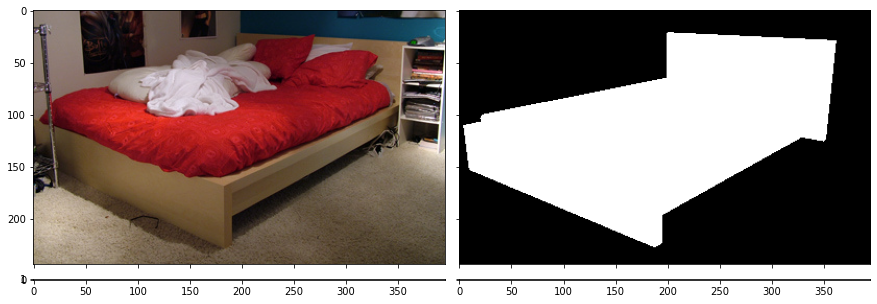

In [8]:
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.2,)
for ax, im in zip(grid, [img, mask]):
    ax.imshow(im)

plt.show()

Convert a voxel data to a point cloud.

In [9]:
# TODO : change point cloud or mesh
point_cloud = voxel_to_point(voxel)
max_xyz = np.max(point_cloud, axis=0)
min_xyz = np.min(point_cloud, axis=0)

point_cloud -= (max_xyz - min_xyz) / 2 + min_xyz

# scaling point cloud to real size
v_x_size = np.max(point_cloud[:, 0]) - np.min(point_cloud[:, 0])
x_size = np.max(vertices[:, 0]) - np.min(vertices[:, 0])
scale = x_size / v_x_size
point_cloud = tr.scaling(point_cloud, np.array([scale, scale, scale]))

obj_point_cloud = jv.point(point_cloud, single_color('#ff0000', len(point_cloud)), point_size=0.005)
obj_mesh = jv.mesh(vertices, triangles)
jv.display([obj_mesh, obj_point_cloud])

Output()

Project a point cloud to an image.

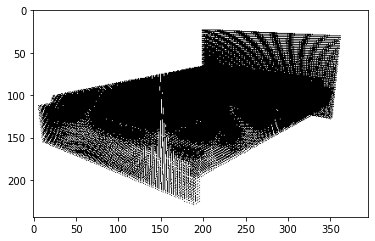

In [15]:
img_x, img_y = info["img_size"]
focal_length = info["focal_length"]
sensor_width = 32 # mm
rotation_matrix = np.array(info["rot_mat"])
translation_matrix = np.array(info["trans_mat"])

fx = fy = focal_length / sensor_width * img_x
cx = img_x / 2
cy = img_y / 2

p_img, _ = point_to_image(point_cloud, img_y, img_x, fx, fy, cx, cy, rotation_matrix, translation_matrix)
plt.imshow(p_img)

## References
- [Sun, Xingyuan, Jiajun Wu, Xiuming Zhang, Zhoutong Zhang, Chengkai Zhang, Tianfan Xue, Joshua B. Tenenbaum, and William T. Freeman. 2018. “Pix3D: Dataset and Methods for Single-Image 3D Shape Modeling.” In 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition. IEEE. https://doi.org/10.1109/cvpr.2018.00314.](https://openaccess.thecvf.com/content_cvpr_2018/html/Sun_Pix3D_Dataset_and_CVPR_2018_paper.html)